<img align="left" width="30%" style="padding-right:10px;" src="Images/Ccom.png">

___
# Review of Linear Algebra
## 4 Solution of Nonlinear Equations
<br>
Original Linear Algebra text and in text examples:
David E. Wells, Kresho Frankich, 1994

Minor additional notes and edits: Semme J. Dijkstra, 2022<br>
Additional examples: : Semme J. Dijkstra, 2022<br>
Jupyter Notebook Implementation: Semme J. Dijkstra, 2022<br>
Python code and explanations: Semme J. Dijkstra, 2022

<a href="https://teams.microsoft.com/l/team/19%3auL2OnH3RSfCWwU2Fd3VYGLT_03BYOfA3KB_OBp10CIY1%40thread.tacv2/conversations?groupId=5c11a428-14b6-429d-b7f5-a61ebc0a440b&tenantId=d6241893-512d-46dc-8d2b-be47e25f5666"><img src="Images/help.png"  title="Ask questions on Teams" align="right" width="10%" alt="Teams.com\"></a><br><br> 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sin, cos, sqrt
import numpy.linalg as la
from my_code.latex_output import display_matrix, latex_matrix
from my_code.boat import boat
from my_code.set_limit import set_limit
from my_code.plottransform import plottransform
from IPython.display import display, Math, Markdown, Latex
# %matplotlib notebook
from matplotlib.animation import FuncAnimation
%load_ext autoreload
%autoreload 2


___
<img align="left" width="6%" style="padding-right:10px;" src="./Images/info.png">

# LaTex<br>

This is a [Jupyter](https://jupyter.org/) notebook in which heavy use of [LaTex](https://www.latex-project.org/) is made. LaTex is *\"a high-quality typesetting system; it includes features designed for the production of technical and scientific documentation. LaTeX is the de facto standard for the communication and publication of scientific documents.\"* according to [the Latex project](https://www.latex-project.org/)

Latex allows the creation of macros and other type-setting methods of convenience. This particular Markdown cell you are reading is used for the definition of new LaTex operators and commands, but they are hidden from view. If you are interested: double click on this cell to enter its edit mode and you will be able see how they are implemented.

<div hidden>
$\usepackage{amsmath,amssymb}$

$\DeclareRobustCommand{\bbone}{\text{\usefont{U}{bbold}{m}{n}1}}$

$\DeclareMathOperator{\EX}{\mathbb{E}}% expected value$

$\DeclareMathOperator{\res}{\vec{r}}$

$\DeclareMathOperator{\mf}{\mu_{1}\sigma_{2}^{2}+\mu_{2}\sigma_{1}^{2}\over{\sigma_{1}^{2} + \sigma_{2}^{2}}}$
    
$\DeclareMathOperator{\sf}{{\sigma_{1}^{2}\sigma_{2}^{2}}\over{\sigma_{1}^{2}+\sigma_{2}^{2}}}$
    
$\newcommand{\ex}[1]{\mathbb{E}\{#1\}}$
    
$\newcommand{\dev}[1]{\mathbb{E}\{#1^o_i - \mathbb{E}\{#1\}\}}$
    
$\newcommand{\cov}[1]{\mathbb{E}\{(#1^o_i - \mathbb{E}\{#1\})(#1 - \mathbb{E}\{#1\})^T\}}$
    
$\newcommand{\m}[1]{\mathbf{#1}}$

$\newcommand{\col}[2]{\begin{pmatrix}#1 \\ #2 \end{pmatrix}}$
    
$\newcommand{\pd}[2]{\dfrac{\partial{\,#1}}{\partial{\,#2}}}$
    
</div>



___
# 5 The Solution of Nonlinear Equations

In most cases, the equations and parameters that we use in Ocean Mapping are **not** linearly related. In order to use the powerful tools that linear algebra provides we must find some way of ***linearizing*** the nonlinear equations. We will require some results from the calculus of matrices in order to do this. The assumption is made that you are familiar with the calculus, but not it's implementation with matrices, thus a short introduction to the topic is provided.

Note that much may be said about this topic. However we will limit the scope to what is required for the *method of the least squares* and *Kalman filtering*, both of which are routinely encountered in Ocean Mapping.


### 5. Self Study Exercise 1

Imagine that you are in a location $x_{obs}$ and are observing distances $l_i$ to three locations $x_i$. The locations and observations are given in the table below


$$\begin{array}{|c|c|c|c|} \text{Location}&\text{Easting}&\text{Northing}&\text{Observation} \\
\hline \\
\m{x}_{obs} & 34682.29 & 198739.81 &   \\
\m{x}_{1} & 34589.76 & 198645.87 &  131.753 \\ 
\m{x}_{2} & 34857.20 & 198628.99 &  207.157 \\
\m{x}_{3} & 34624.74 & 198823.66 &  101.611 \\
\end{array}$$

C0
C1
C2


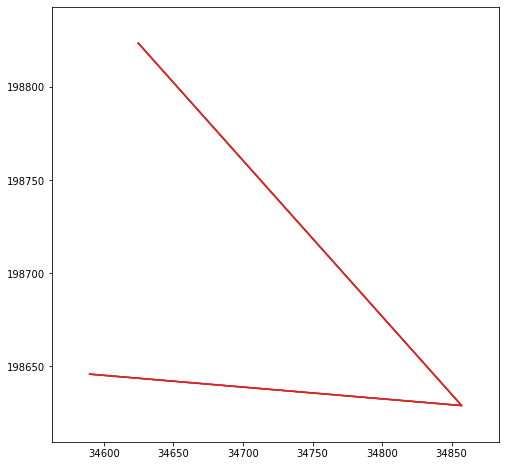

In [20]:
# Define a circle for plotting
t = np.linspace(0,2*pi,100)
circle = np.array([cos(t),sin(t)])

# The (estimated) location of the observer
x_obs = np.array([[ 34682.29],[ 198739.81]])

# The known locations of the stations
x_i = np.array([[ 34589.76, 34857.20, 34624.74],[ 198645.87, 198628.99, 198823.66]])

# The observed distances to the stations
l_obs = np.array([[131.753], [207.157], [101.611]])

# Create the baselines between the observer and the stations `x_i`
bl = x_obs - x_i

# Allocate memory for the observable vector l
l = np.zeros((3,1))

# Model the observations
for i,b in enumerate(bl.T):
    l[i] = sqrt(b.T@b)
    

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
for i,lop in enumerate(l_obs):
    c = 'C'+str(i)
    print(c)
    plt.plot(x_i[0],x_i[1],color = 'C3')

plot_limits = set_limit(x_i)
ax1.set_xlim(plot_limits[0])
ax1.set_ylim(plot_limits[1])
plt.show()

In [8]:
set_limit(x_i)

array([[ 34563.016,  34883.944],
       [198609.523, 198843.127]])

___
## 5.1 Matrix Calculus

In these notebooks the elements of matrix $\m{A}$ have so-far been numbers. However, you may now assume that the elements of matrix $\m{A}$ are differentiable functions of a variable $x$ i.e., $a_{ij}=a_{ij}(x)$. Then the derivative of $\m{A}$ is defined as the matrix whose elements are the derivatives of the corresponding elements of $\m{A}$. 

For example, for

$$\m{A} = \begin{pmatrix} a_{11}(x) & a_{12}(x) \\ a_{21}(x) & a_{22}(x) \end{pmatrix}\tag{204}$$

the derivative of $\m{A}$ is

$$\dfrac{d\m{A}}{dx} = \begin{pmatrix} \dfrac{d\,a_{11}(x)}{dx} & \dfrac{d\,a_{12}(x)}{dx} \\ \dfrac{d\,a_{21}(x)}{dx} & \dfrac{d\,a_{22}(x)}{dx} \end{pmatrix}\tag{205}$$

If $\m{A}$ is the product of two other matrices $\m{B}$ and $\m{C}$, whose elements are also differentiable functions of $x$, then
<a id='eq206'></a>
$$\m{A}=\m{BC}\tag{206}$$

has the derivative:

$$\dfrac{d\m{A}}{dx} = \dfrac{d\m{\,BC}}{dx} = \dfrac{d\m{\,B}}{dx}\m{C}+\m{B}\dfrac{d\m{C}}{dx}\tag{207}$$

if $\m{C}$ is nonsingular, it has an inverse and we find from [(206)](#eq206):

$$\m{B}=\m{AC}^{-1}\tag{208}$$

which may be differentiated as (by rewriting [(207)](#eq207))

$$\dfrac{d\m{\,B}}{dx}=\dfrac{d\m{AC}^{-1}}{dx}=\dfrac{d\m{A}}{dx}\m{C}^{-1}-\m{A}\m{C}^{-1}\dfrac{d\m{C}}{dx}\m{C}^{-1}\tag{209}$$

Note that [(207)](#eq207) and [(209)](#eq209) are analogous to the derivatives of $a(x) = b(x)c(x)$ and $b(x)=a(x)/b(x)$. However, because matrices are generally not commutative the order in [(207)](#eq207) and [(209)](#eq209) cannot be altered.

In the quadratic form

$$l^2 = \m{x}^T\m{Ax}\tag{210}$$

the elements of the matrix $\m{A}$ are considered as constants, and the elements of $\m{x}$ as variables. The derivative of the quadratic form is then

$$dl^2=d\m{x}^T\cdot\m{Ax}+\m{x}^T\m{A}\cdot d{\m{x}}\tag{211}$$

and if $\m{A}$ is symmetric ($\m{A}^T=\m{A}$) then (using [(44)](2_Matrix_Algebra.ipynb#eq44): $(\m{A}\m{B})^T = \m{B}^T\m{A}^T)$

$$dl^2=2\m{x}^T\m{A}\cdot d{\m{x}}\tag{212}$$

thus

$$\dfrac{d\m{x}^T\m{Ax}}{d\m{x}}=2\m{x}^T\m{A}\tag{213}$$

___
## 5.2 Partial Differentiation

Consider a column vector $\m{y}$ having $m$ elements, each of which is function of *several* variables $(x_1, x_2, \dots, x_n)$. Let $\m{x}$ be the column vector whose elements are these variables. If we adopt the convention that the derivatives of $y_1$ form a row vector, it has the form

$$\pd{y_1}{\m{x}}=\begin{pmatrix}\pd{y_1}{x_1}&\pd{y_1}{x_2}&\dots&\pd{y_1}{x_n}\end{pmatrix}\tag{214}$$

By this convention the derivative of the entire vector $\m{y}$ becomes an array

$$\pd{y}{\m{x}}=\begin{pmatrix}
\pd{y_1}{x_1}&\pd{y_1}{x_2}&\dots&\pd{y_1}{x_n} \\
\pd{y_2}{x_1}&\pd{y_2}{x_2}&\dots&\pd{y_2}{x_n} \\
\vdots&\vdots&\ddots&\vdots \\
\pd{y_n}{x_1}&\pd{y_n}{x_2}&\dots&\pd{y_n}{x_n}\end{pmatrix}\tag{215}$$

the $(i,j)$ element of which is given by $\pd{y_i}{x_j}$. The total differential of 